In [1]:
#Python Project
#Geospatial Analysis with Python and R
#Marieke Scheel
#27.12.2022

In [2]:
#import necessary packages
import geopandas as gpd
import pandas as pd
import numpy as np
import fiona 
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt
import matplotlib as mpl
from osgeo import gdal
from rasterstats import zonal_stats
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
import folium
import branca
from shapely.geometry import Point
from folium import plugins

# show less rows but more columns
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)

C:\Users\marie\AppData\Local\Temp\ipykernel_12728\2919154090.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [3]:
#import river line file (all in EU)
file="CCM21_LAEA_RiverBasins\ccm21\LAEA_RiverBasins.gdb"

# Get the desired layer from the .gdb file 
layers = fiona.listlayers(file)
for layer in layers:
    mainrivers_eu = gpd.read_file(file,layer="MAINRIVERS")
#mainrivers_eu.crs #EPSG 3035

In [4]:
#import discharge points
file="eea_disc\GDB\DischargePoints_public.gdb"

# Get the desired layer from the .gdb file 
layers = fiona.listlayers(file)
for layer in layers:
    disc_eu = gpd.read_file(file,layer="UWWTD_DischargePoints")
    
#transform crs to same as mainrivers_eu
disc_proj=disc_eu.to_crs(epsg=3035)

In [5]:
#import country borders with counties
file=r"C:\Users\marie\Documents\GEM_Master\Tartu\GeospatialAnalysis\geopython2022\Python_proj\ne_10m_admin_1_states_provinces\ne_10m_admin_1_states_provinces.shp"

#read shapefile
countr = gpd.read_file(file)
sweden = countr.loc[countr['admin'] == "Sweden"]

#transform crs
sweden_proj=sweden.to_crs(epsg=3035)

#make Sweden mask for clipping by dissolving counties
merged_swed = sweden_proj.dissolve(by = 'admin')

In [6]:
#import raster
src = rasterio.open('g100_00\g100_00.tif')
#src.crs #EPSG 3035

In [7]:
##clip discharge, river and raster by sweden_proj

#clip discharge points
#create buffer around discharge points and clip buffers and points
mask_int = disc_proj['geometry'].within(merged_swed.iloc[0].geometry)
disc_buf=disc_proj
disc_buf['buf_geom']=disc_proj.buffer(5000) #5km buffer around points
disc_swed_buf=disc_buf[mask_int] #mask the buffer 
disc_swed_pts=disc_proj[mask_int] #mask the points

#clip rivers
mask_int = mainrivers_eu['geometry'].within(merged_swed.iloc[0].geometry)
rivers_swed=mainrivers_eu[mask_int]

#clip raster with Sweden Polygon
out_image, out_transform = mask(dataset=src, shapes=merged_swed['geometry'], crop=True)
out_meta = src.meta.copy()
out_meta.update({"driver": "GTiff",
                  "height": out_image.shape[1],
                  "width": out_image.shape[2],
                  "transform": out_transform})
src.close()

with rasterio.open("g100_clipped.tif", "w", **out_meta) as dest:
     dest.write(out_image)

#plot clipped vector files 
#base=sweden_proj.plot(color='yellow')
#disc_swed_pts.plot(ax=base, markersize=0.4, color="red")
#rivers_swed.plot(ax=base, linewidth=0.4)

#plot clipped raster
#cmap = plt.cm.viridis
#with rasterio.open("g100_clipped.tif", 'r') as data:
#    print(data.profile)
#    show(data, cmap=cmap)

In [8]:
#Reclassification of array
driver = gdal.GetDriverByName('GTiff')
file = gdal.Open('g100_clipped.tif')
band = file.GetRasterBand(1)
g100_ar = band.ReadAsArray()

# reclassification to larger classes based on CLC legend
for j in  range(file.RasterXSize):
    for i in  range(file.RasterYSize):
        if 0 < g100_ar[i,j] <= 11:
            g100_ar[i,j] = 1 #Artificial Surfaces
        elif 11 < g100_ar[i,j] <= 22:
            g100_ar[i,j] = 2 #Agricultural Surfaces
        elif 22 < g100_ar[i,j] <= 34:
            g100_ar[i,j] = 3 #Forest and seminatural areas
        elif 34 < g100_ar[i,j] <= 39:
            g100_ar[i,j] = 4 #Wetlands
        elif 39 < g100_ar[i,j] <= 44:
            g100_ar[i,j] = 5 # Water Bodies
        elif g100_ar[i,j] > 48:
            g100_ar[i,j] = 6 #Unclassified
        else:
            g100_ar[i,j] = g100_ar[i,j]

#print unique values in reclassified array
#values= np.unique(g100_ar, return_counts=True)
#print(values)

In [9]:
##save reclassified land use raster
#open clipped unreclassified
src = rasterio.open('g100_00\g100_00.tif')
#src.plot.imshow()

#save g100_ar array to land_recl.tif
with rasterio.open('land_recl.tif', 'w',
driver=src.driver,height=src.height,width=src.width,count=src.count,crs=src.crs, transform=src.transform,dtype=src.read().dtype) as dst:
            dst.write(g100_ar, indexes=1)
src.close()

In [10]:
##calculate majority of land use in discharge buffers and counties
#copy dischage buffers to new gdf
disc_swed_buf2 = disc_swed_buf

#drop point geometry, set buffer geometry to new geom
disc_swed_buf2 = disc_swed_buf.drop(columns='geometry')
disc_swed_buf2 = disc_swed_buf2.set_geometry('buf_geom')

#drop date columns (cannot be converted to shapefile)
disc_swed_buf2 = disc_swed_buf2.drop(disc_swed_buf2.iloc[:,21:28], axis=1)

#to shapefile
disc_swed_buf2.to_file('disc_swed_buf.shp')
sweden_proj.to_file('sweden_counties.shp')

#zonal statistics 
stats_buf= pd.DataFrame(zonal_stats('disc_swed_buf.shp', 'land_recl.tif', stats='majority', preserve_ids=True))
stats_cnts= pd.DataFrame(zonal_stats('sweden_counties.shp', 'land_recl.tif', stats='majority', preserve_ids=True))

#reset index for join
disc_swed_buf3 = disc_swed_buf2.reset_index(drop=True)
disc_swed_pts1 = disc_swed_pts.reset_index(drop=True)
sweden_proj1 = sweden_proj.reset_index(drop=True)

#join buffer file to majority stat file
disc_swed_buf3 = disc_swed_buf3.join(stats_buf)
disc_swed_pts2 = disc_swed_pts1.join(stats_buf)
sweden_proj1 = sweden_proj1.join(stats_cnts)

#count occurence of unique majority values 
values_buf= np.unique(disc_swed_buf3['majority'], return_counts=True)
values_cnt= np.unique(sweden_proj1['majority'], return_counts=True)
#print(values_buf) #(array([3., 4., 5.]), array([345,  20,  12], dtype=int64)) #visualise buffers because of higher variety compared to counties
#print(values_cnt) #(array([3.]), array([21], dtype=int64))

C:\Users\marie\AppData\Local\Temp\ipykernel_12728\782491739.py:13: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  disc_swed_buf2.to_file('disc_swed_buf.shp')
C:\Users\marie\.conda\envs\geopython2022\lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\marie\.conda\envs\geopython2022\lib\site-packages\rasterstats\io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
C:\Users\marie\.conda\envs\geopython2022\lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\marie\.conda\envs\geopython2022\lib\site-packages\ra

In [11]:
##find and count rivers intersecting with discharge buffer

#recalculate buffer with only geometry attribute
mask_int = disc_proj['geometry'].within(merged_swed.iloc[0].geometry)
disc_buf=disc_proj.buffer(5000) #5km buffer around points
disc_swed_buf=disc_buf[mask_int] #mask the buffer 

#GeoSeries to Geodataframe
disc_swed_buf = gpd.GeoDataFrame(disc_swed_buf, crs="EPSG:3035", geometry=0)
rivers_swed = gpd.GeoDataFrame(rivers_swed, crs="EPSG:3035")

#join buffers and rivers that intersect
river_disc_intersect = gpd.sjoin(disc_swed_buf, rivers_swed, op='intersects')

#merge with rivers by ID to get geometry of rivers
river_disc_intersect = river_disc_intersect.merge(rivers_swed, on='ID')

#add wkt column with geometry for grouping
river_disc_intersect['riv_geom_wkt'] = river_disc_intersect['geometry'].to_wkt()
river_disc_gr = river_disc_intersect.groupby('riv_geom_wkt').count().reset_index()
river_disc_gr = river_disc_gr.merge(river_disc_intersect, on='riv_geom_wkt') #add geometries back to counted and grouped gdf

#extract geometries and count to new geodataframes
river_disc_bufs1 = pd.DataFrame ([river_disc_gr.loc[:,'0_y'], river_disc_gr.loc[:,'0_x']])
river_disc_bufs1 = river_disc_bufs1.transpose()
river_disc_bufs1 = river_disc_bufs1.rename(columns ={'0_y':'geometry'})
river_disc_bufs1 = river_disc_bufs1.rename(columns ={'0_x':'count'})
river_disc_bufs2 = gpd.GeoDataFrame(river_disc_bufs1, crs="EPSG:3035")
river_disc_rivs1 = pd.DataFrame ([river_disc_gr.loc[:,'geometry_y'], river_disc_gr.loc[:,'0_x']])
river_disc_rivs1 = river_disc_rivs1.transpose()
river_disc_rivs1 = river_disc_rivs1.rename(columns ={'geometry_y':'geometry'})
river_disc_rivs1 = river_disc_rivs1.rename(columns ={'0_x':'count'})
river_disc_rivs2 = gpd.GeoDataFrame(river_disc_rivs1, crs="EPSG:3035")

C:\Users\marie\.conda\envs\geopython2022\lib\site-packages\IPython\core\interactiveshell.py:3373: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [12]:
##count discharge points per county
#calculate area of counties
sweden_proj["area"] = sweden_proj['geometry'].area/ 10**9 #area in 1000 km2

#join disc pts and counties
pointInPolys = gpd.sjoin(sweden_proj, disc_swed_pts, predicate='intersects', how='left')

#group joined df by county name and count point occurence (duplication of names)
pointInPolys_gr = pointInPolys.groupby('name').count().reset_index()

#select only name and counts of featurecla in list and make it a df
disc_in_cnts_count = [pointInPolys_gr['name'], pointInPolys_gr['featurecla']]
disc_cnts_count_df = pd.DataFrame (disc_in_cnts_count)
disc_cnts_count_df = disc_cnts_count_df.transpose()
disc_cnts_count_df=disc_cnts_count_df.rename(columns ={'featurecla':'disc_count'})

#merge county gdf with counts
county_count_gpd = sweden_proj.merge(disc_cnts_count_df, on='name')

#calculate density of discharge points in counties (points/1000km2)
county_count_gpd['Point Density']=county_count_gpd['disc_count']/county_count_gpd['area']

#round value for visualisation (tooltip)
county_count_gpd['Point Density']=county_count_gpd['Point Density'].apply(lambda x: round(x, 2))

C:\Users\marie\.conda\envs\geopython2022\lib\site-packages\geopandas\plotting.py:807: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  cat = pd.Categorical(values, categories=categories)


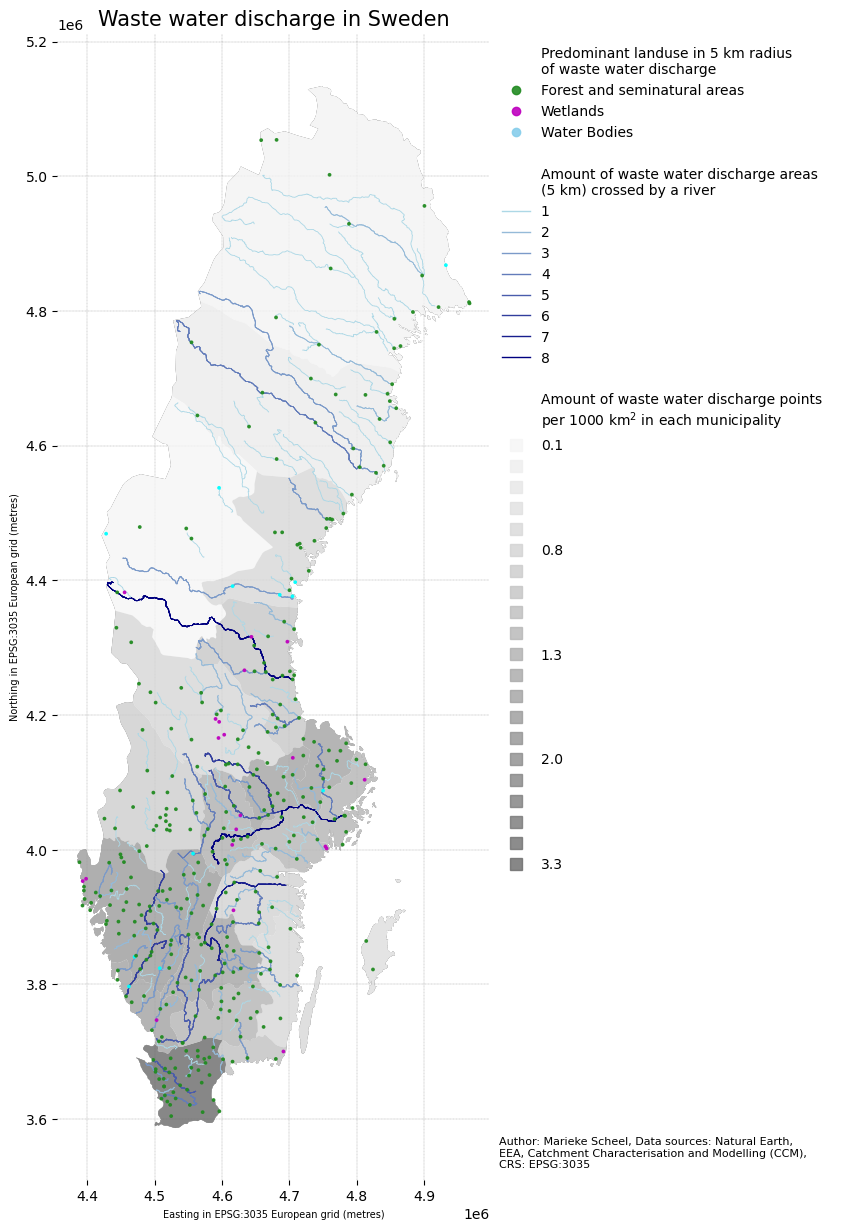

In [13]:
#plot static map
fig, ax = plt.subplots()

#colour schemes
colormap1=sns.blend_palette(['whitesmoke', 'dimgrey'], n_colors=20, as_cmap=True) #for counties
colormap3=sns.blend_palette(['lightblue', 'navy'], n_colors=20, as_cmap=True) #for rivers
vals = np.ones((3, 4)) #for landuse in buffers
vals[0] = mpl.colors.to_rgba('forestgreen')
vals[1] = mpl.colors.to_rgba('m')
vals[2] = mpl.colors.to_rgba('aqua')
newcmp = ListedColormap(vals)

#plot data
merged_swed.plot(ax=ax, linestyle='-', linewidth=20, color= 'black', zorder=0); #for outline sweden
merged_swed.plot(ax=ax, linestyle='-', linewidth=0, color= 'white', zorder=1); #for alpha background must be white
county_count_gpd.plot(ax=ax, column="Point Density",cmap=colormap1, alpha=0.8, zorder=2); #discharge point density in counties
river_disc_rivs2.plot(ax=ax, column="count", linewidth=0.6,cmap=colormap3, zorder=3) #amount of discharge areas crossed by individual rivers
disc_swed_pts2.plot(ax=ax, column="majority",cmap=newcmp, alpha=0.9, markersize=3, zorder=4) #predominant land use in discharge areas

#plot layout
plt.grid(color = 'dimgrey', linewidth = 0.2, alpha=1, linestyle ='--')
plt.tight_layout()
fig.set_figwidth(10)
fig.set_figheight(14)
ax2 = fig.gca()
ax2.spines['bottom'].set_linewidth(0)
ax2.spines['top'].set_linewidth(0)
ax2.spines['left'].set_linewidth(0)
ax2.spines['right'].set_linewidth(0)

#build legend manually
legend_elements = [Line2D([0],[0], markersize=0,label='Predominant landuse in 5 km radius \nof waste water discharge', lw=0),
                   Line2D([0],[0],marker='o',markersize=6,color='forestgreen',label='Forest and seminatural areas', lw=0, alpha=0.9),
                   Line2D([0],[0],marker='o',markersize=6,color='m',label='Wetlands', lw=0, alpha=0.9),
                   Line2D([0],[0],marker='o',markersize=6,color='skyblue',label='Water Bodies', lw=0, alpha=0.9),
                   Line2D([0],[0],label='', lw=0, markersize=0),
                   Line2D([0],[0],label='Amount of waste water discharge areas\n(5 km) crossed by a river', lw=0),
                   Line2D([0],[0],color=colormap3(0),label='1', lw=1),
                   Line2D([0],[0],color=colormap3(1/7),label='2', lw=1),
                   Line2D([0],[0],color=colormap3(2/7),label='3', lw=1),
                   Line2D([0],[0],color=colormap3(3/7),label='4', lw=1),
                   Line2D([0],[0],color=colormap3(4/7),label='5', lw=1),
                   Line2D([0],[0],color=colormap3(5/7),label='6', lw=1),
                   Line2D([0],[0],color=colormap3(6/7),label='7', lw=1),
                   Line2D([0],[0],color=colormap3(7/7),label='8', lw=1),
                   Line2D([0],[0],label='', lw=0, markersize=0),
                   Line2D([0],[0],label='Amount of waste water discharge points \nper 1000 $\mathregular{km^{2}}$ in each municipality', lw=0),
                   Line2D([0],[0],marker='s', color=colormap1(0/20), markersize=8, label='0.1', lw=0, alpha=0.8),
                   Line2D([0],[0],marker='s', color=colormap1(1/20), markersize=8, label='', lw=0, alpha=0.8),
                   Line2D([0],[0],marker='s', color=colormap1(2/20), markersize=8, label='', lw=0, alpha=0.8),
                   Line2D([0],[0],marker='s', color=colormap1(3/20), markersize=8, label='', lw=0, alpha=0.8),
                   Line2D([0],[0],marker='s', color=colormap1(4/20), markersize=8, label='', lw=0, alpha=0.8),
                   Line2D([0],[0],marker='s', color=colormap1(5/20), markersize=8, label='0.8', lw=0, alpha=0.8),
                   Line2D([0],[0],marker='s', color=colormap1(6/20), markersize=8, label='', lw=0, alpha=0.8),
                   Line2D([0],[0],marker='s', color=colormap1(7/20), markersize=8, label='', lw=0, alpha=0.8),
                   Line2D([0],[0],marker='s', color=colormap1(8/20), markersize=8, label='', lw=0, alpha=0.8),
                   Line2D([0],[0],marker='s', color=colormap1(9/20), markersize=8, label='', lw=0, alpha=0.8),
                   Line2D([0],[0],marker='s', color=colormap1(10/20), markersize=8, label='1.3', lw=0, alpha=0.8),
                   Line2D([0],[0],marker='s', color=colormap1(11/20), markersize=8, label='', lw=0, alpha=0.8),
                   Line2D([0],[0],marker='s', color=colormap1(12/20), markersize=8, label='', lw=0, alpha=0.8),
                   Line2D([0],[0],marker='s', color=colormap1(13/20), markersize=8, label='', lw=0, alpha=0.8),
                   Line2D([0],[0],marker='s', color=colormap1(14/20), markersize=8, label='', lw=0, alpha=0.8),
                   Line2D([0],[0],marker='s', color=colormap1(15/20), markersize=8, label='2.0', lw=0, alpha=0.8),
                   Line2D([0],[0],marker='s', color=colormap1(16/20), markersize=8, label='', lw=0, alpha=0.8),
                   Line2D([0],[0],marker='s', color=colormap1(17/20), markersize=8, label='', lw=0, alpha=0.8),
                   Line2D([0],[0],marker='s', color=colormap1(18/20), markersize=8, label='', lw=0, alpha=0.8),
                   Line2D([0],[0],marker='s', color=colormap1(19/20), markersize=8, label='', lw=0, alpha=0.8),
                   Line2D([0],[0],marker='s', color=colormap1(20/20), markersize=8, label='3.3', lw=0, alpha=0.8)]
ax.legend(handles=legend_elements, numpoints=1, labelspacing=0.5, loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

#title and caption
plt.title("Waste water discharge in Sweden", fontsize=15)
anchored_text = AnchoredText('Author: Marieke Scheel, Data sources: Natural Earth, \nEEA, Catchment Characterisation and Modelling (CCM), \nCRS: EPSG:3035', 
                             loc='lower left', bbox_to_anchor=(1., 0.), bbox_transform=ax.transAxes, frameon=False, prop=dict(size=8))
ax.add_artist(anchored_text)

#x and y label
ax.set_ylabel('Northing in EPSG:3035 European grid (metres)', fontsize=7)
ax.set_xlabel('Easting in EPSG:3035 European grid (metres)', fontsize=7)

#save figure
plt.savefig("Sweden_waste_water_discharge.png", bbox_inches="tight")

In [14]:
###interactive map
#reproject layers to wgs84 (necessary for folium)
county_count_gpd_rp = county_count_gpd.to_crs(epsg=4326)
disc_swed_buf3_rp = disc_swed_buf3.to_crs(epsg=4326)
river_disc_rivs2_rp = river_disc_rivs2.to_crs(epsg=4326)

#create index
county_count_gpd_rp['geoid'] = county_count_gpd_rp.index.astype(str)
disc_swed_buf3_rp['geoid'] = disc_swed_buf3_rp.index.astype(str)
river_disc_rivs2_rp['geoid'] = river_disc_rivs2_rp.index.astype(str)
river_disc_rivs2_rp['count'] = river_disc_rivs2_rp['count'].astype(str).astype(float)

#select data columns
county_count_gpd_rp = county_count_gpd_rp[['geoid', 'name', 'Point Density', 'geometry']]
disc_swed_buf3_rp = disc_swed_buf3_rp[['geoid', 'majority', 'buf_geom']]
river_disc_rivs2_rp = river_disc_rivs2_rp[['geoid', 'count', 'geometry']]

#convert the gdfs to geojsons
county_jsontxt = county_count_gpd_rp.to_json()

#create basemap
m = folium.Map(location=[63.8, 16.5], zoom_start=5, control_scale=True, prefer_canvas=True, width=600, height=900, tiles="cartodbpositron", min_zoom=2.5)

#add tiled layers to map
tiles=["stamenterrain", "cartodbpositron", "openstreetmap"]
for tile in tiles:
    folium.TileLayer(tile).add_to(m)

In [15]:
#plot waste water point density in municipalities
munic_cnt=folium.Choropleth(
      geo_data=county_jsontxt,
      data=county_count_gpd_rp,
      columns=['geoid', 'Point Density'],
      key_on="feature.id",
      fill_opacity=0.5,
      line_opacity=0.2,
      line_color='white',
      line_weight=0,
      legend_name='Amount of waste water discharge points per 1000 km\u00b2 in each municipality',
      name='Municipalities',
      highlight=False,
      fill_color='YlOrBr'
 ).add_to(m)

#add tooltip with name and density
folium.GeoJsonTooltip(['name', 'Point Density']).add_to(munic_cnt.geojson);

In [16]:
#Plot rivers and amount of discharge areas that they cross

#create suitable colormap
colormap4=sns.blend_palette(['lightblue', 'navy'], n_colors=8, as_cmap=True)
cm1 = branca.colormap.StepColormap([colormap4(0),colormap4(1/7),colormap4(2/7),colormap4(3/7),colormap4(4/7),colormap4(5/7),colormap4(6/7),colormap4(7/7)], 
                                   vmin=1, vmax=8, index=[1,2,3,4,5,6,7,8], caption='Amount of waste water discharge areas (5 km) crossed by a river', max_labels=8)

#define line to points function
def getLinesAsPointList(row, geom):
    list_x = list(row[geom].coords.xy[0])
    list_y = list(row[geom].coords.xy[1])
    return list(zip(list_y, list_x))
   
#Explode Multilinestrings to Linestrings
river_disc_rivs2_rp2 = river_disc_rivs2_rp.explode(index_parts=True)

#calculate x and y coordinates of the line
river_disc_rivs2_rp2['points_list'] = river_disc_rivs2_rp2.apply(getLinesAsPointList, geom='geometry', axis=1)

#list of lat lon coordinate pairs
riv_pts = []
for a in river_disc_rivs2_rp2['points_list'].tolist():
    if len(a) >=2:
        riv_pts.append(a)

#initiate feature group for interactive use of lines in plot
fg=folium.FeatureGroup(name='Amount of waste water discharge areas (5 km) crossed by a river', show=True)

#plot lines in respective colors and add to feature group
for row, pt in enumerate(riv_pts):
    if river_disc_rivs2_rp2.loc[river_disc_rivs2_rp2.index[row], 'count']==1:
        folium.PolyLine(locations=pt, color=cm1(1), popup='1',
                    weight=1, opacity=1).add_to(fg)
    elif river_disc_rivs2_rp2.loc[river_disc_rivs2_rp2.index[row], 'count']==2:
        folium.PolyLine(locations=pt, color=cm1(2), popup='2',
                    weight=1, opacity=1).add_to(fg)
    elif river_disc_rivs2_rp2.loc[river_disc_rivs2_rp2.index[row], 'count']==3:
        folium.PolyLine(locations=pt, color=cm1(3), popup='3',
                    weight=1, opacity=1).add_to(fg)
    elif river_disc_rivs2_rp2.loc[river_disc_rivs2_rp2.index[row], 'count']==4:
        folium.PolyLine(locations=pt, color=cm1(4), popup='4',
                    weight=1, opacity=1).add_to(fg)
    elif river_disc_rivs2_rp2.loc[river_disc_rivs2_rp2.index[row], 'count']==5:
        folium.PolyLine(locations=pt, color=cm1(5), popup='5',
                    weight=1, opacity=1).add_to(fg)
    elif river_disc_rivs2_rp2.loc[river_disc_rivs2_rp2.index[row], 'count']==6:
        folium.PolyLine(locations=pt, color=cm1(6), popup='6',
                    weight=1, opacity=1).add_to(fg)
    elif river_disc_rivs2_rp2.loc[river_disc_rivs2_rp2.index[row], 'count']==7:
        folium.PolyLine(locations=pt, color=cm1(7), popup='7',
                    weight=1, opacity=1).add_to(fg)
    elif river_disc_rivs2_rp2.loc[river_disc_rivs2_rp2.index[row], 'count']==8:
        folium.PolyLine(locations=pt, color=cm1(8), popup='8',
                    weight=1, opacity=1).add_to(fg)
    else:
        folium.PolyLine(locations=pt, color='', popup=river_disc_rivs2_rp2.loc[river_disc_rivs2_rp2.index[row], 'count'],
                    weight=0, opacity=1).add_to(fg)
        
#add both legend and feature group to plot
m.add_child(fg);
m.add_child(cm1);

In [17]:
#Plot land use in discharge areas

#create discrete values in colormap
colormap5=sns.blend_palette(['forestgreen', 'm', 'aqua'], n_colors=3, as_cmap=True) #for rivers
cm2 = branca.colormap.StepColormap([colormap5(0),colormap5(1/2),colormap5(2/2)],
                                   vmin=2.5, vmax=5.5, index=[2.5,3.5,4.5], tick_labels=[3, 4, 5], caption='Predominant land use in 5 km radius of waste water discharge (CLC Landcover class)', max_labels=3)

#define points to coordinates function
def getPoints(row, geom):
    if isinstance(row[geom], Point):
        return [row[geom].y, row[geom].x]
    else:
        return ()

#project to wgs84 and get lat and lon of points
disc_swed_pts2_rp = disc_swed_pts2.to_crs(epsg=4326)
disc_swed_pts2_rp['points_tuple'] = disc_swed_pts2_rp.apply(getPoints, geom='geometry', axis=1)

# list of lat lon coordinate pair tuples
disc_pts = []
for a in disc_swed_pts2_rp['points_tuple'].tolist():
    if len(a) >=2:
        disc_pts.append(a)

#initiate feature group for interactive use of points in plot
fg1=folium.FeatureGroup(name='Predominant land use in 5 km radius of waste water discharge', show=False)

#plot points in respective colors and add to feature group
for idx, pt in enumerate(disc_pts):
    if disc_swed_pts2_rp.loc[disc_swed_pts2_rp.index[idx], 'majority']==3:
        folium.CircleMarker(location=pt, popup='Forest and seminatural areas', color="forestgreen", radius=1, opacity=1).add_to(fg1)
    elif disc_swed_pts2_rp.loc[disc_swed_pts2_rp.index[idx], 'majority']==4:
        folium.CircleMarker(location=pt, popup='Wetlands', color="magenta", radius=1, opacity=1).add_to(fg1)
    elif disc_swed_pts2_rp.loc[disc_swed_pts2_rp.index[idx], 'majority']==5:
        folium.CircleMarker(location=pt, popup= 'Water Bodies', color="aqua", radius=1, opacity=1).add_to(fg1)

#add both legend and feature group to plot
m.add_child(fg1);
m.add_child(cm2);

In [18]:
#add layout features
#add global minimap for overview of location
minimap = plugins.MiniMap()
m.add_child(minimap);

#add layer control (turn layers on and off)
folium.LayerControl(position='topright', collapsed=True).add_to(m)

#add title
title_html = '''
             <h3 align="left" style="font-size:16px"><b>{}</b></h3>
             '''.format('Waste water discharge in Sweden')   
m.get_root().html.add_child(folium.Element(title_html))

In [19]:
m.save("Interactive_wasterwater_Sweden.html")
m